# G$_0$W$_0$@PBE

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import numpy as np
import os
from scipy.signal import argrelextrema

# Find files
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

        
def distance(vec1,vec2):
    return np.linalg.norm(vec1-vec2)


def angle(vec1,vec2,vec3):
    vec4 = (vec1-vec2)/np.linalg.norm(vec1-vec2)
    vec5 = (vec3-vec2)/np.linalg.norm(vec3-vec2)
    dot_product = np.dot(vec4,vec5)
    return np.arccos(dot_product)*180/np.pi

# Get labels
def getlabels(filename):
    #
    # read xyz file
    #
    with open(filename,'r') as f:
        natoms = int(f.readline())
        nmol = int(natoms/3)
        molecules = np.zeros((nmol,3,3))
        f.readline()
        geometry = np.zeros((natoms,3))
        atoms = []
        for atom in range(natoms):
            line = f.readline().split()
            atoms.append(line[0])
            geometry[atom] = line[1:]
    #
    # find each water molecule
    #
    oxygens = geometry[np.array(atoms)=='O']
    hydrogens = geometry[np.array(atoms)=='H']
    for oxygen in range(len(oxygens)):
        molecules[oxygen,0] = oxygens[oxygen]
        ih = 0
        for hydrogen in range(len(hydrogens)):
            if distance(oxygens[oxygen],hydrogens[hydrogen]) < 1.2:
                ih += 1
                molecules[oxygen,ih] = hydrogens[hydrogen]
                if ih == 2: break
    #
    # Search hydrogen bonds
    #
    hbonds = [{"D":0, "A":0} for imol in range(nmol)]
    for imol in range(nmol):
        o1 = molecules[imol,0]
        h11 = molecules[imol,1]
        h12 = molecules[imol,2]
        for jmol in range(imol+1,nmol):
            o2 = molecules[jmol,0]
            h21 = molecules[jmol,1]
            h22 = molecules[jmol,2]
            roo = (distance(o1,o2) - 3.3)/0.00044
            roo = (distance(o1,o2) - 3.3)/0.00043
            if roo > 0.0: continue
            if roo <= -angle(h11,o1,o2)**2 or roo <= -angle(h12,o1,o2)**2: 
                hbonds[imol]["D"] += 1
                hbonds[jmol]["A"] += 1
            if roo <= -angle(h21,o2,o1)**2 or roo <= -angle(h22,o2,o1)**2:
                hbonds[imol]["A"] += 1
                hbonds[jmol]["D"] += 1
    #
    # Return hydrogen-bond labels for each water molecule
    #
    return ["A"*int(hbonds[imol]["A"])+"D"*int(hbonds[imol]["D"]) for imol in range(nmol)]


# Use of LaTeX is optional
usetex = True

# Read JSON file into a Pandas DataFrame
g0w0_df = pd.read_json("df_g0w0.json", orient="split")

# Colors dictionary
colors_dict = {
    'None'  : 'yellow',
    'A'     : "tab:blue",
    'D'     : "tab:orange",
    'AA'    : "tab:red",
    'AD'    : "tab:green",
    'DD'    : "tab:purple",
    'AAD'   : "tab:brown",
    "ADD"   : "tab:pink",
    "AADD"  : "tab:olive",
    "AAADD" : "black",
}


# Extract data into appropriate Lists
x = [ i+1 for i in range(len(g0w0_df["energies_pbeh"])) for j in g0w0_df["energies_pbeh"][i]]
pbeh = [item for sublist in g0w0_df["energies_pbeh"].values for item in sublist]
g0w0 = [item for sublist in g0w0_df["energies_g0w0"].values for item in sublist]
colors = [colors_dict[item] for sublist in g0w0_df["labels"].values for item in sublist]
labels = g0w0_df["shortname"]

# Escape underscores in labels if usetex = True
if usetex: labels = [item.translate(str.maketrans({"_": r"\_"})) for item in labels]

In [8]:
colors_new = []
imol = 0
for file in g0w0_df["filename"]:
    path = find(file,"../xyz")
    _labels = getlabels(path)
    _labels = [_labels[i-1] for i in g0w0_df["mol_indices"][imol]]
    imol += 1
    for label in _labels:
        if label == '': label = 'None'
        colors_new.append(colors_dict[label])

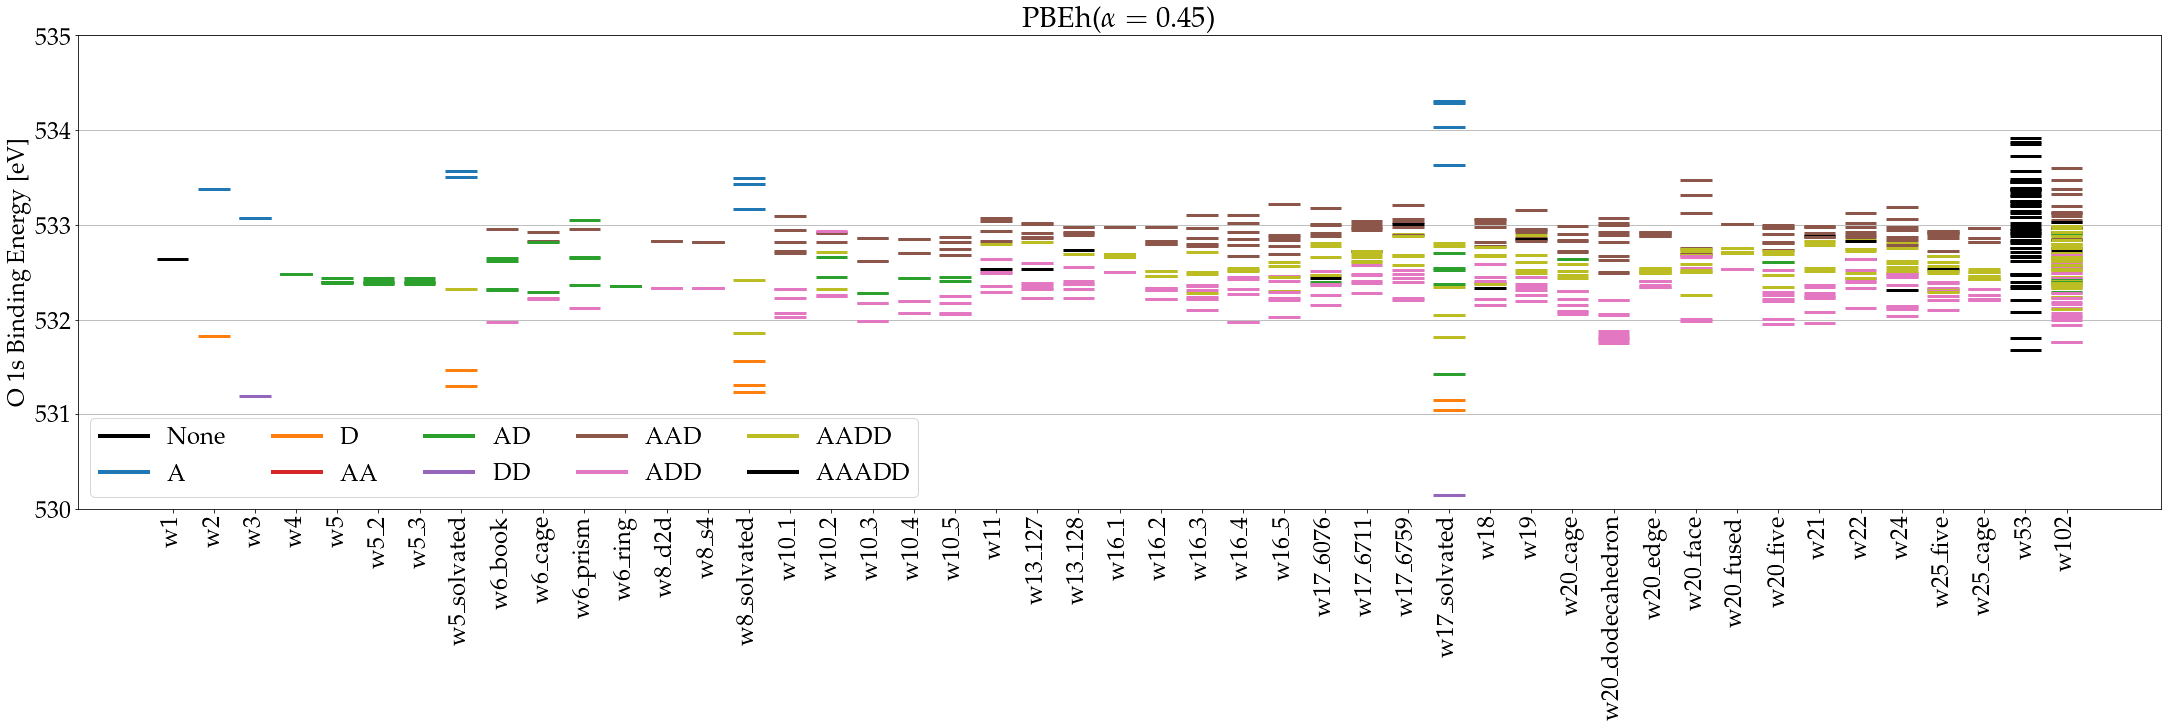

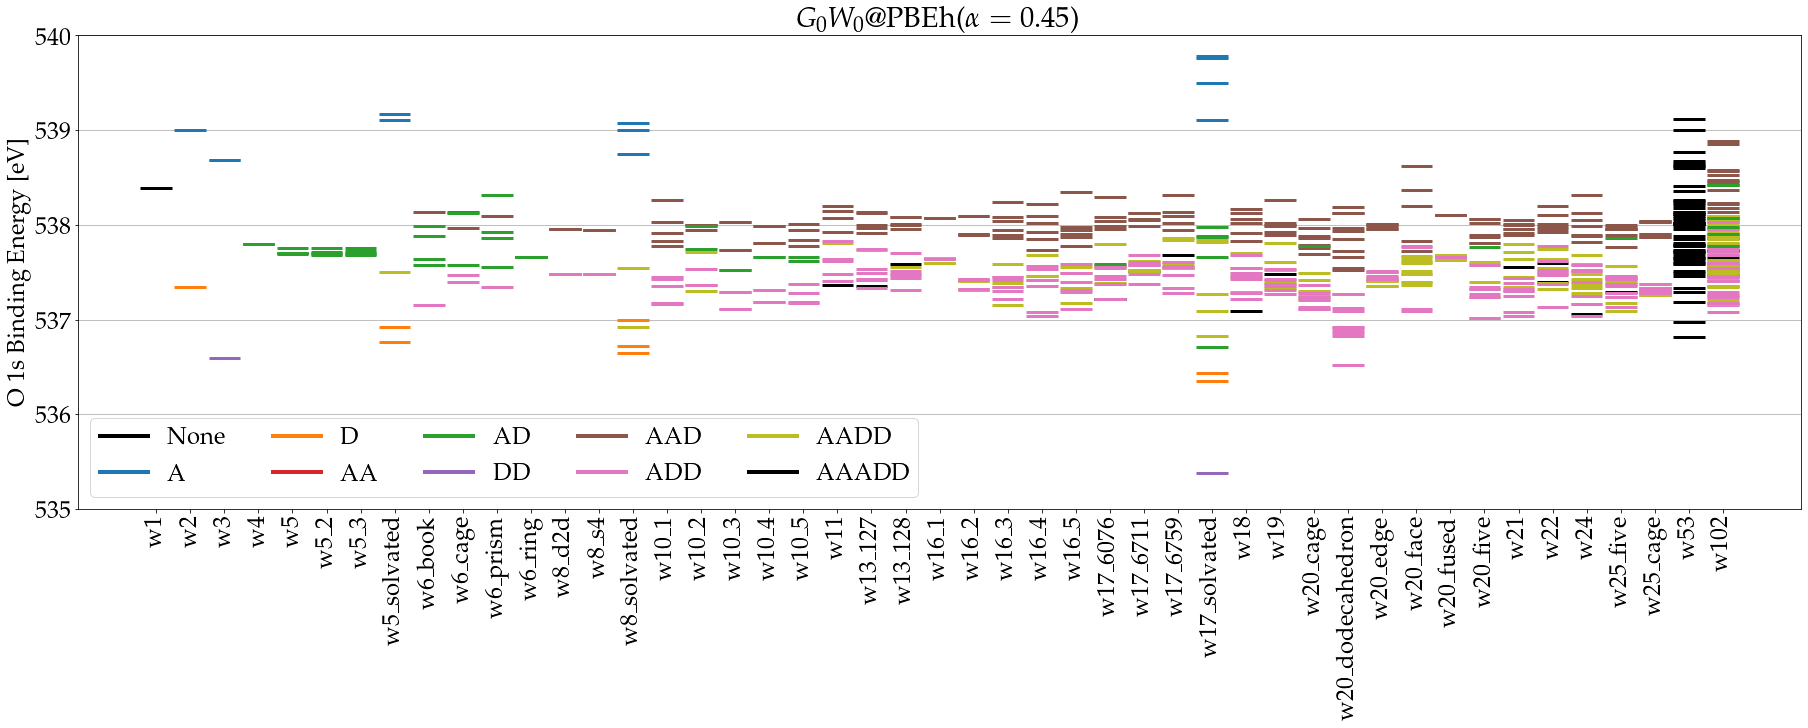

In [15]:
# Plots

plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    'font.size': 24
})

# Legends
lines = [Line2D([0], [0], color=colors_dict['None'], lw=4),
         Line2D([0], [0], color=colors_dict['A'], lw=4),
         Line2D([0], [0], color=colors_dict['D'], lw=4),
         Line2D([0], [0], color=colors_dict['AA'], lw=4),
         Line2D([0], [0], color=colors_dict['AD'], lw=4),
         Line2D([0], [0], color=colors_dict['DD'], lw=4),
         Line2D([0], [0], color=colors_dict['AAD'], lw=4),
         Line2D([0], [0], color=colors_dict['ADD'], lw=4),
         Line2D([0], [0], color=colors_dict['AADD'], lw=4),
         Line2D([0], [0], color=colors_dict['AAADD'], lw=4)
        ]


# GKS Eigenvalues
fig, ax = plt.subplots(figsize=(30,10),constrained_layout=True)
ax.scatter(x,pbeh,marker='_',s=1000,zorder=3,linewidth=3,color=colors)
ax.set_xticks(range(1,len(g0w0_df)+1))
ax.set_xticklabels(labels,rotation=90)
ax.set_ylabel('O 1s Binding Energy [eV]')
ax.set_title(r'PBEh($\alpha=0.45$)')
ax.set_ylim(530,535)
ax.grid(axis='y')
ax.legend(lines, ['None','A',"D","AA","AD","DD","AAD","ADD","AADD","AAADD"],loc='lower left',ncol=5)
plt.show()

# G_0W_0 Energies
fig, ax = plt.subplots(figsize=(25,10),constrained_layout=True)
ax.scatter(x,g0w0,marker='_',s=1000,zorder=3,linewidth=3,color=colors)
ax.set_xticks(range(1,len(g0w0_df)+1))
ax.set_xticklabels(labels,rotation=90)
ax.set_ylabel('O 1s Binding Energy [eV]')
ax.set_title(r'$G_0W_0$@PBEh($\alpha=0.45$)')
ax.set_ylim(535,540)
ax.grid(axis='y')
ax.legend(lines, ['None','A',"D","AA","AD","DD","AAD","ADD","AADD","AAADD"],loc='lower left',ncol=5)
fig.savefig("g0w0_at_pbeh.pdf",bbox_inches="tight")
plt.show()

In [51]:
# Extract data into appropriate Lists
monomers_labels = ["w1","w5_solvated","w17_solvated", "w53"]
monomers_df = g0w0_df[g0w0_df.shortname.isin(monomers_labels)]
monomers = [item for sublist in monomers_df["energies_g0w0"].values for item in sublist]
xmonomers = [ i+1 for i in range(len(monomers_df["energies_g0w0"])) for j in monomers_df["energies_g0w0"].values[i] ]
monomers_colors = [colors_dict[item] for sublist in monomers_df["labels"].values for item in sublist]

dimers_labels = ["w2","w8_solvated"]
dimers_df = g0w0_df[g0w0_df.shortname.isin(dimers_labels)]
dimers = [item for sublist in dimers_df["energies_g0w0"].values for item in sublist]
xdimers = [ i+1 for i in range(len(dimers_df["energies_g0w0"])) for j in dimers_df["energies_g0w0"].values[i] ]
dimers_colors = [colors_dict[item] for sublist in dimers_df["labels"].values for item in sublist]

fives_labels = ["w11", "w13_127", "w13_128", "w17_6076", "w17_6711", "w17_6759", "w18", "w19", "w20_five", "w21", "w22", "w24", "w25_five", "w102"]
fives_df = g0w0_df[g0w0_df.shortname.isin(fives_labels)]
fives = [item for sublist in fives_df["energies_g0w0"].values for item in sublist]
xfives = [ i+1 for i in range(len(fives_df["energies_g0w0"])) for j in fives_df["energies_g0w0"].values[i] ]
fives_colors = [colors_dict[item] for sublist in fives_df["labels"].values for item in sublist]

# Escape underscores in labels if usetex = True
if usetex: 
    monomers_labels = [item.translate(str.maketrans({"_": r"\_"})) for item in monomers_labels]
    dimers_labels = [item.translate(str.maketrans({"_": r"\_"})) for item in dimers_labels]
    fives_labels = [item.translate(str.maketrans({"_": r"\_"})) for item in fives_labels]

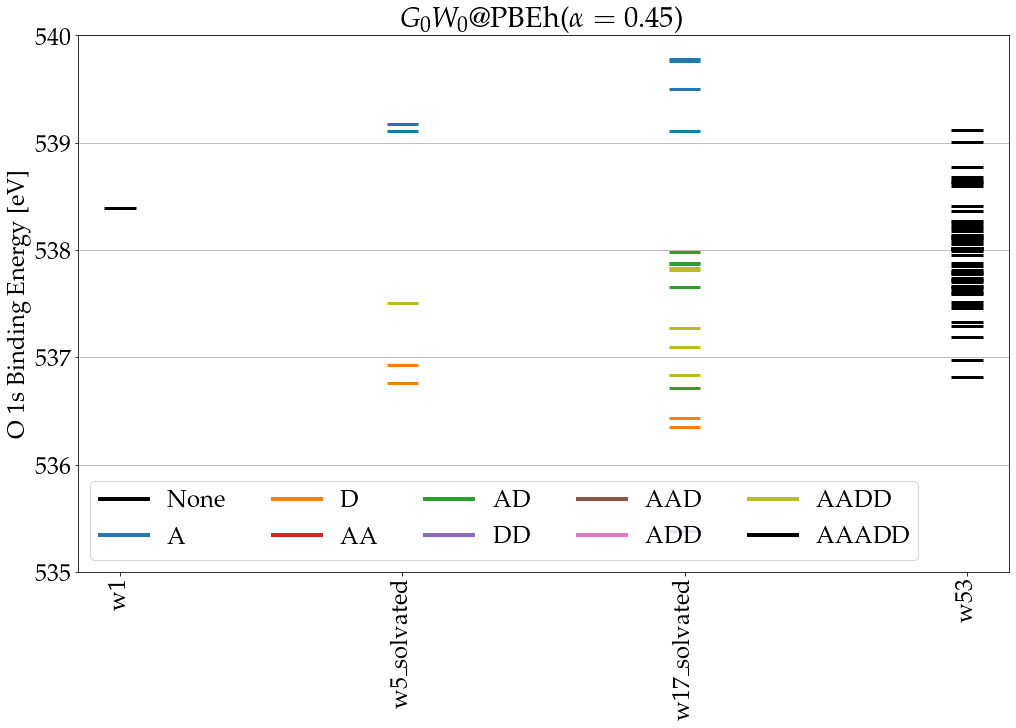

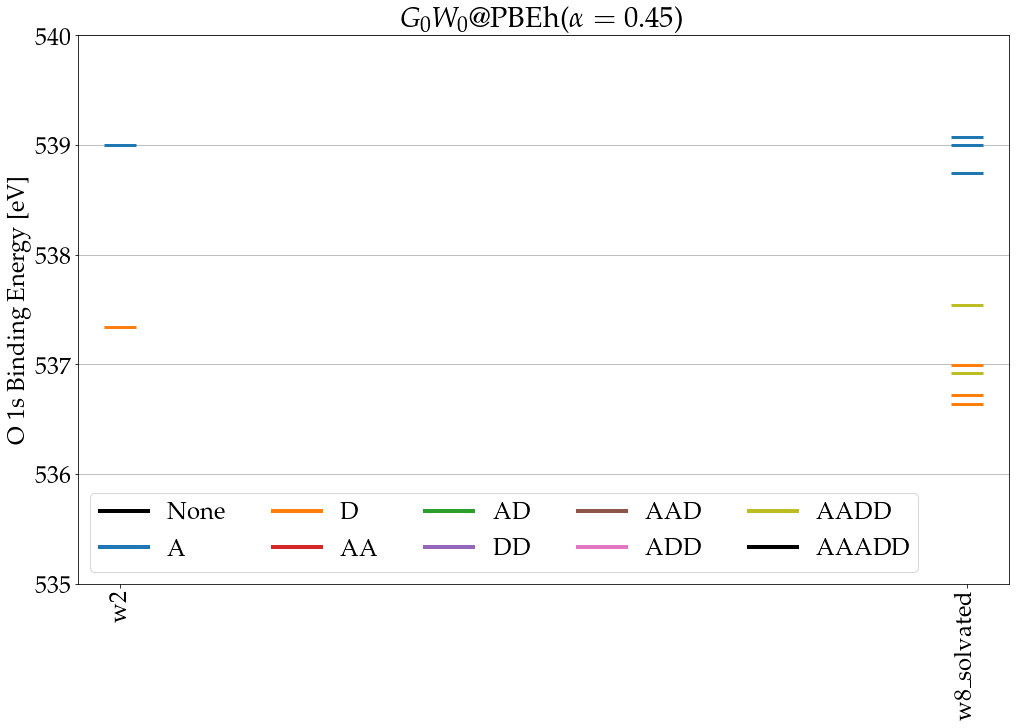

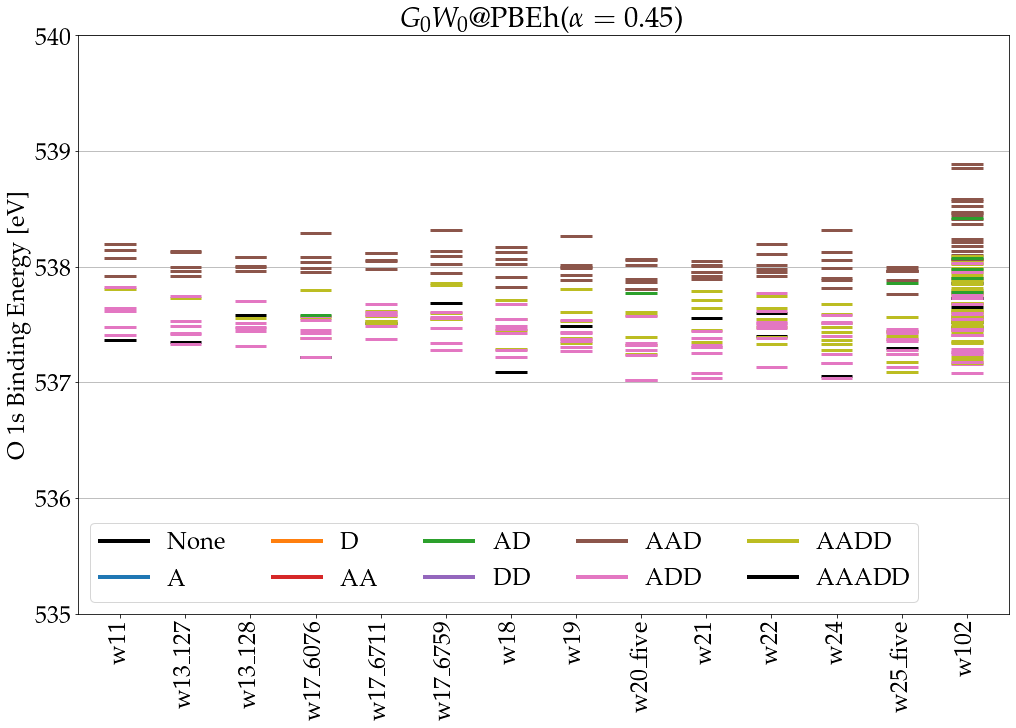

In [64]:
# G_0W_0 Energies
fig, ax = plt.subplots(figsize=(14,10),constrained_layout=True)
ax.scatter(xmonomers,monomers,marker='_',s=1000,zorder=3,linewidth=3,color=monomers_colors)
ax.set_xticks(range(1,len(monomers_df)+1))
ax.set_xticklabels(monomers_labels,rotation=90)
ax.set_ylabel('O 1s Binding Energy [eV]')
ax.set_title(r'$G_0W_0$@PBEh($\alpha=0.45$)')
ax.set_ylim(535,540)
ax.grid(axis='y')
ax.legend(lines, ['None','A',"D","AA","AD","DD","AAD","ADD","AADD","AAADD"],loc='lower left',ncol=5)
fig.savefig("monomers_g0w0_at_pbeh.pdf",bbox_inches="tight")
plt.show()

# G_0W_0 Energies
fig, ax = plt.subplots(figsize=(14,10),constrained_layout=True)
ax.scatter(xdimers,dimers,marker='_',s=1000,zorder=3,linewidth=3,color=dimers_colors)
ax.set_xticks(range(1,len(dimers_df)+1))
ax.set_xticklabels(dimers_labels,rotation=90)
ax.set_ylabel('O 1s Binding Energy [eV]')
ax.set_title(r'$G_0W_0$@PBEh($\alpha=0.45$)')
ax.set_ylim(535,540)
ax.grid(axis='y')
ax.legend(lines, ['None','A',"D","AA","AD","DD","AAD","ADD","AADD","AAADD"],loc='lower left',ncol=5)
fig.savefig("dimers_g0w0_at_pbeh.pdf",bbox_inches="tight")
plt.show()

# G_0W_0 Energies
fig, ax = plt.subplots(figsize=(14,10),constrained_layout=True)
ax.scatter(xfives,fives,marker='_',s=1000,zorder=3,linewidth=3,color=fives_colors)
ax.set_xticks(range(1,len(fives_df)+1))
ax.set_xticklabels(fives_labels,rotation=90)
ax.set_ylabel('O 1s Binding Energy [eV]')
ax.set_title(r'$G_0W_0$@PBEh($\alpha=0.45$)')
ax.set_ylim(535,540)
ax.grid(axis='y')
ax.legend(lines, ['None','A',"D","AA","AD","DD","AAD","ADD","AADD","AAADD"],loc='lower left',ncol=5)
fig.savefig("five_g0w0_at_pbeh.pdf",bbox_inches="tight")
plt.show()

In [9]:
# Gaussian broadening functions
def gaussian(x,E,F=1.2,h=1.0):
    return h*np.exp(-4*np.log(2.0)*((x-E)/F)**2)

# Lorentzian broadening function
def lorentzian(x,E,F=1.2,h=1.0):
    return h/(1+4*((x-E)/F)**2)

# Sum of Gaussian and Lorentzian broadening functions
def gls(x,E,F=0.8,h=1.0,m=0.5):
    return (1-m)*gaussian(x,E,F,h) + m*lorentzian(x,E,F,h)

# Sum of all points
def spectrum(x, E, broadening=gls, F=0.5, m=0.7, h=1.0):
    spec = np.zeros(len(x))
    for i in range(len(E)):
        spec += broadening(x,E[i],F,h,m)
    return spec

_xs = np.linspace(-542,-534,1001)

plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    'font.size': 24
})

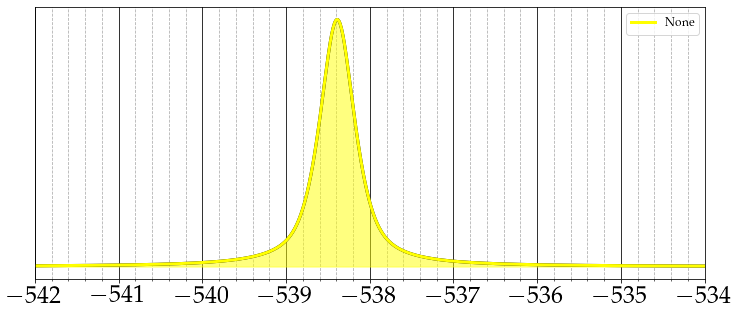

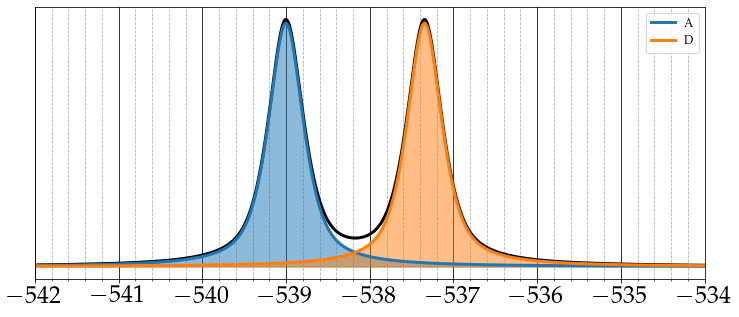

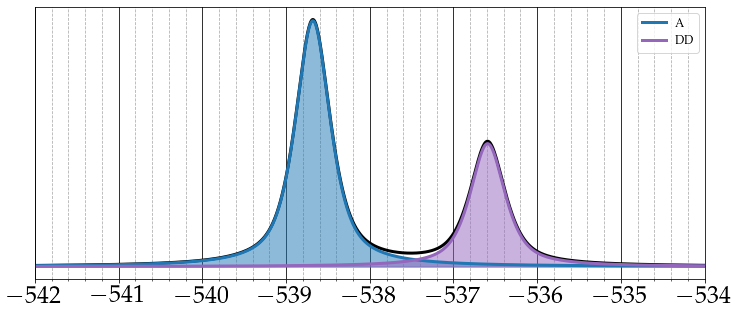

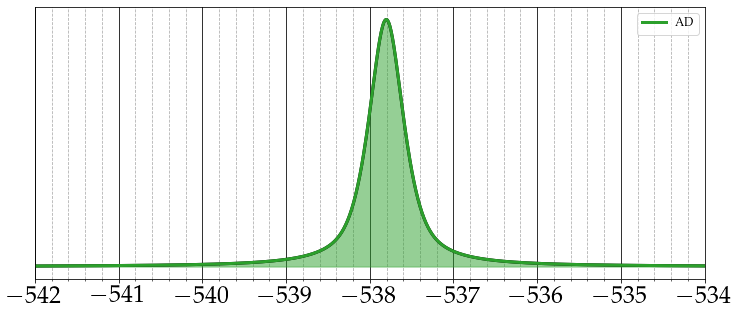

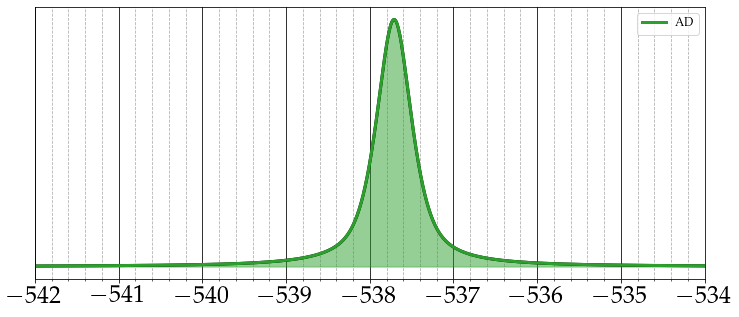

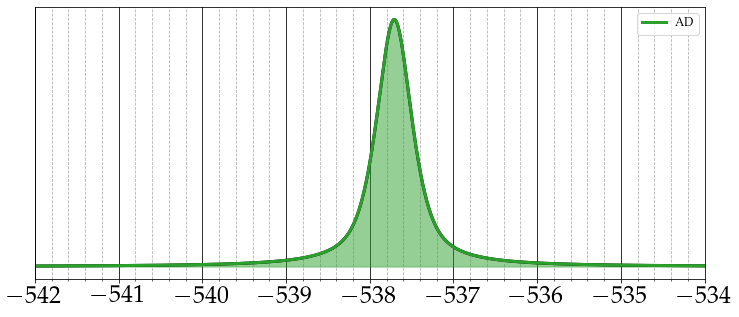

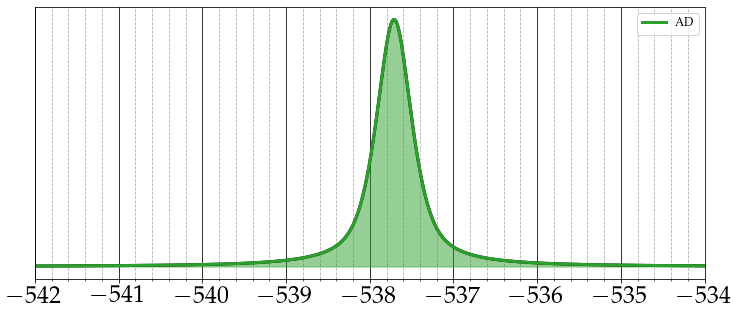

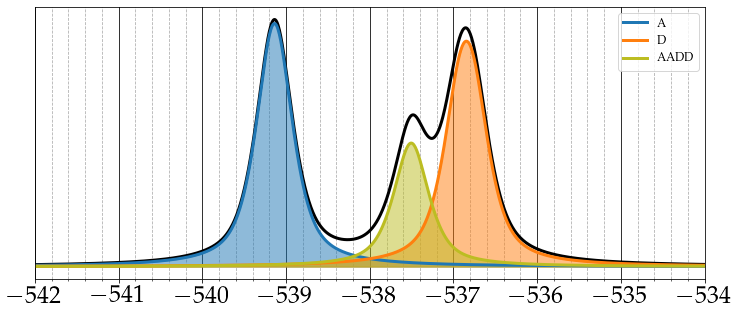

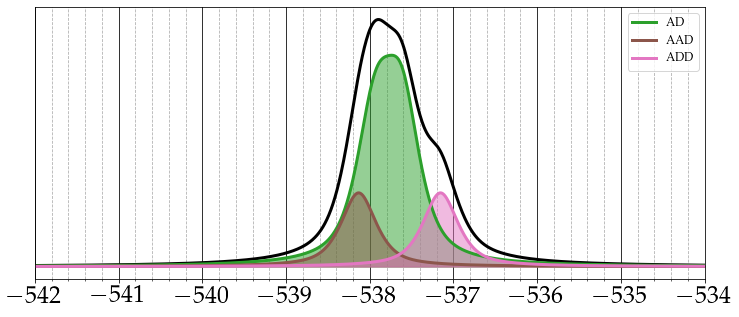

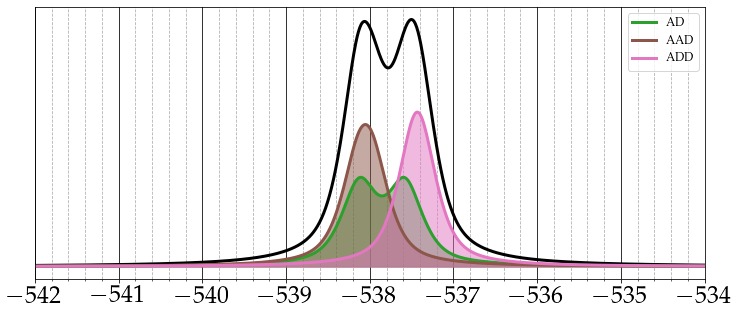

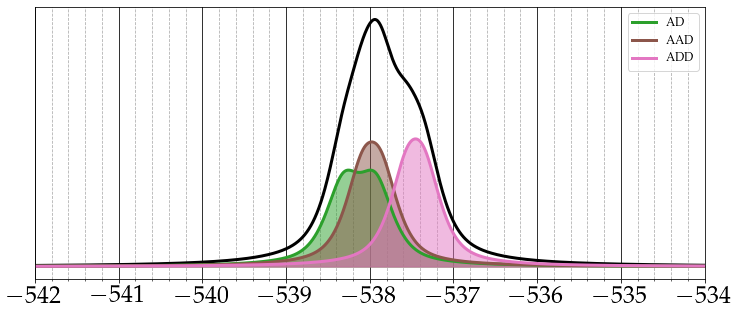

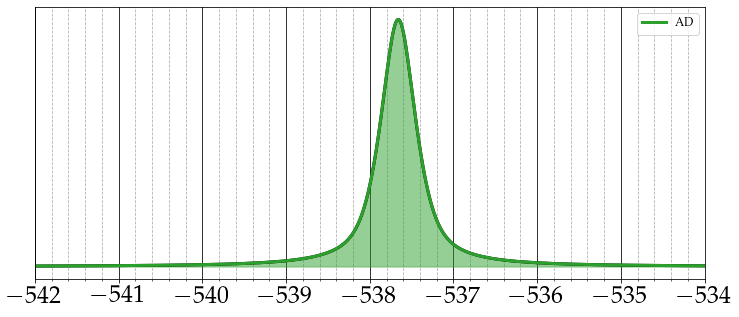

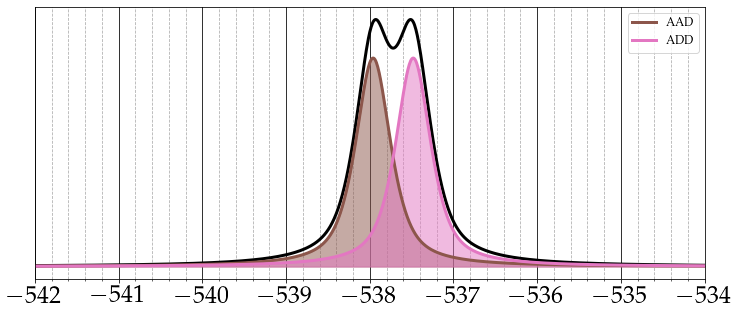

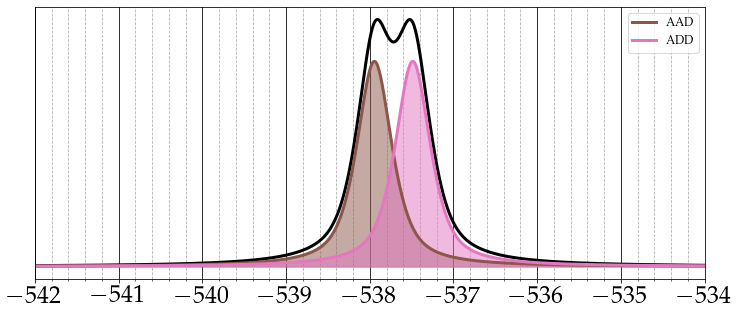

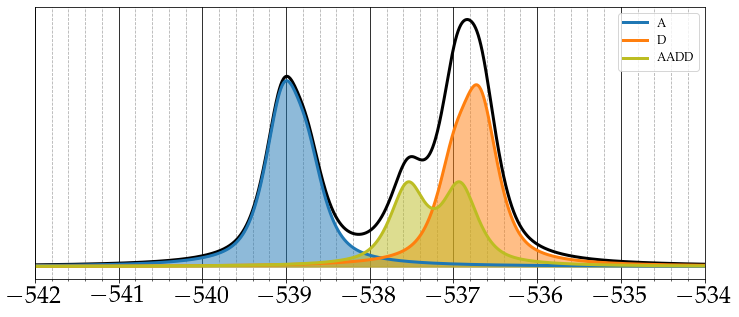

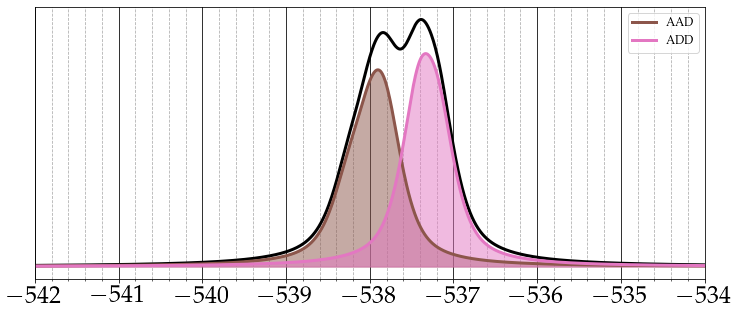

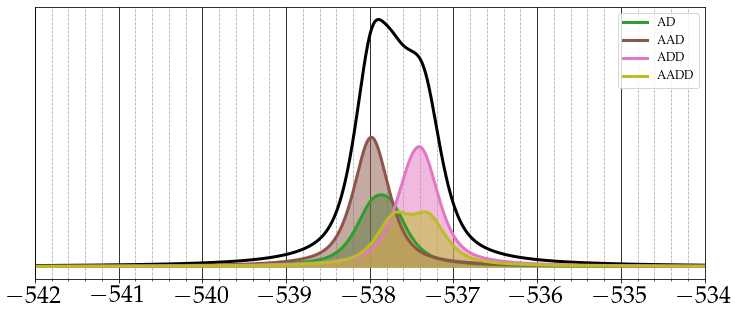

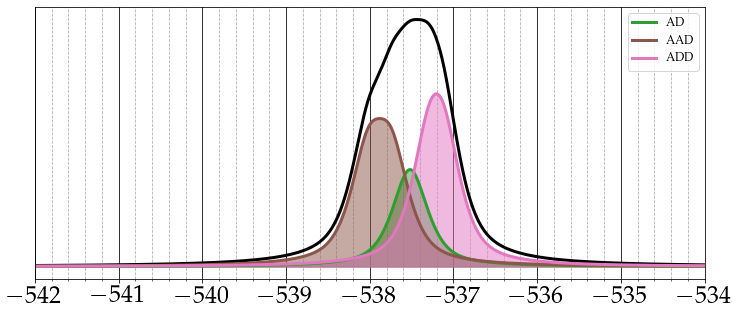

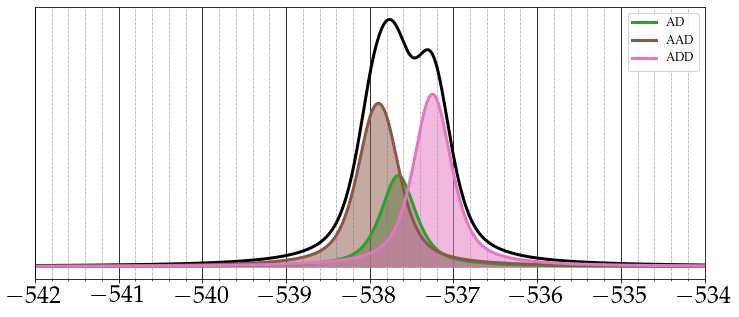

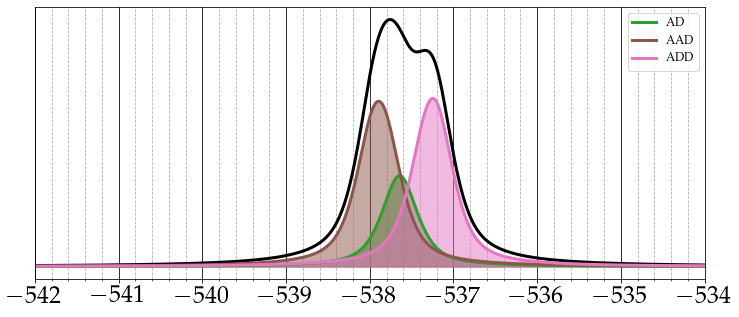

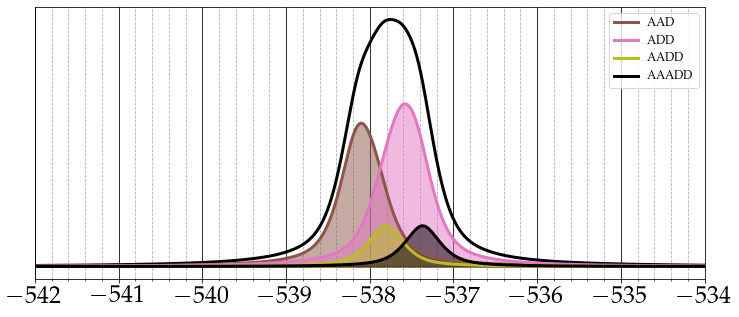

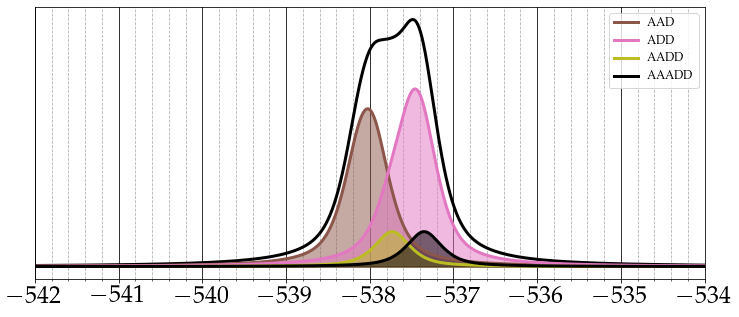

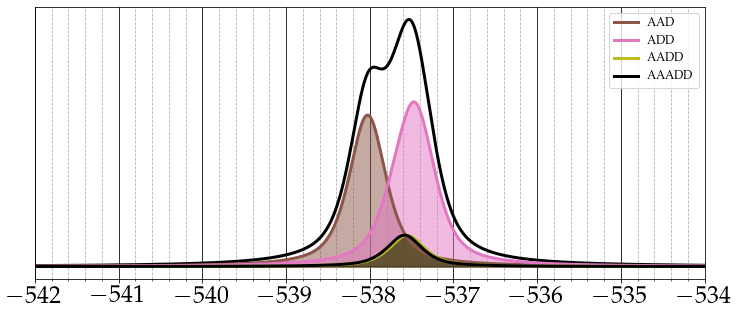

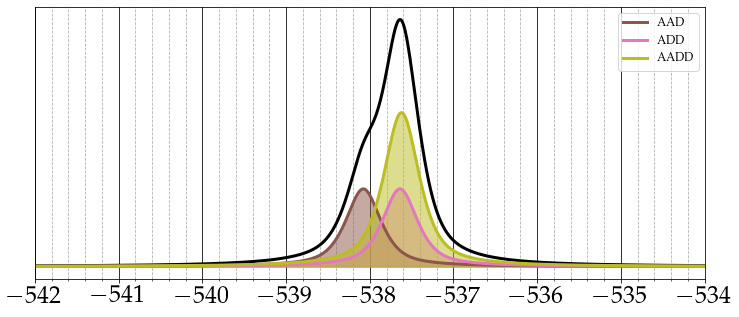

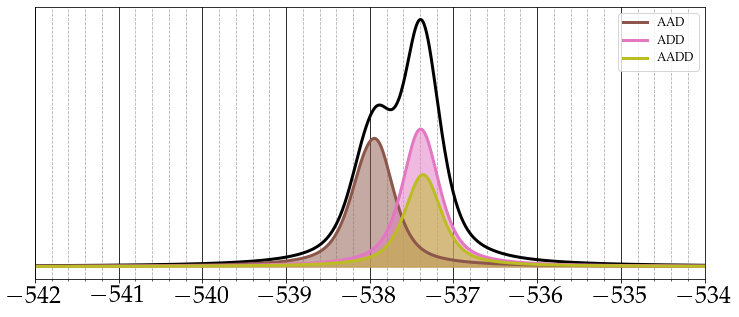

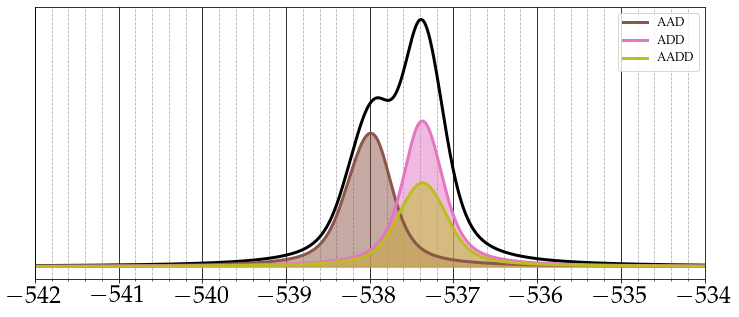

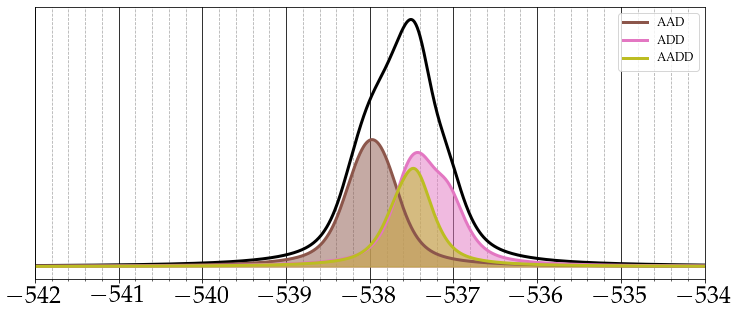

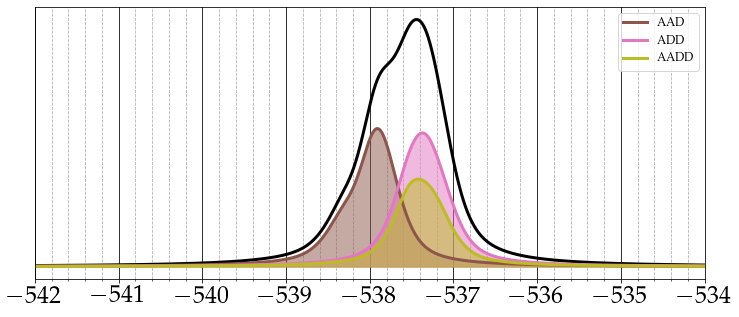

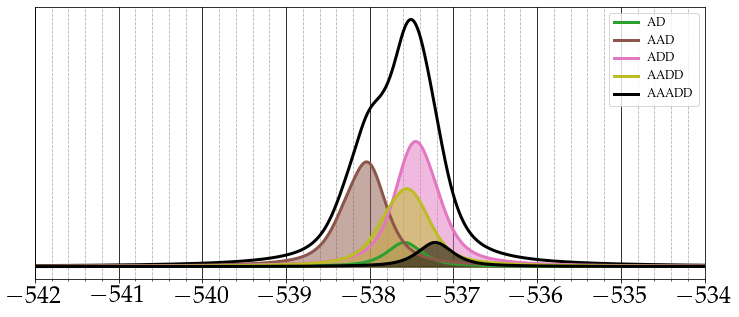

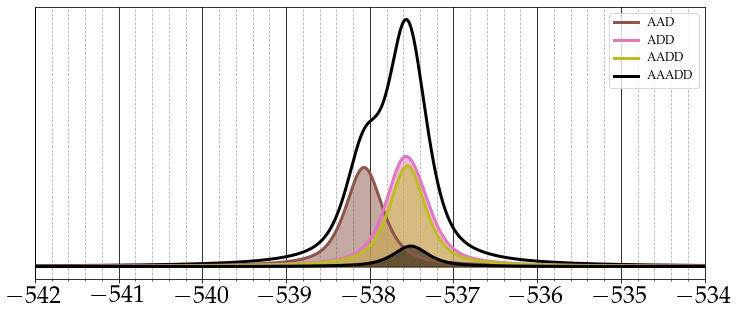

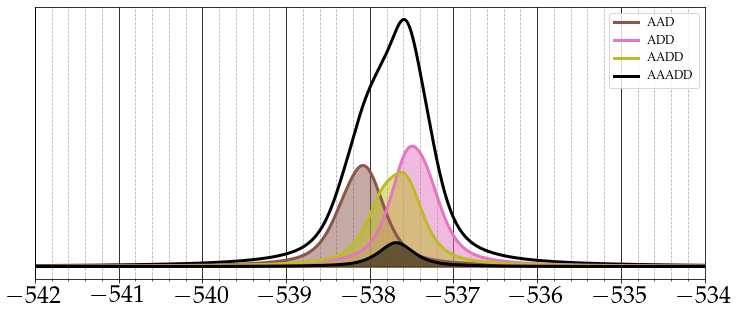

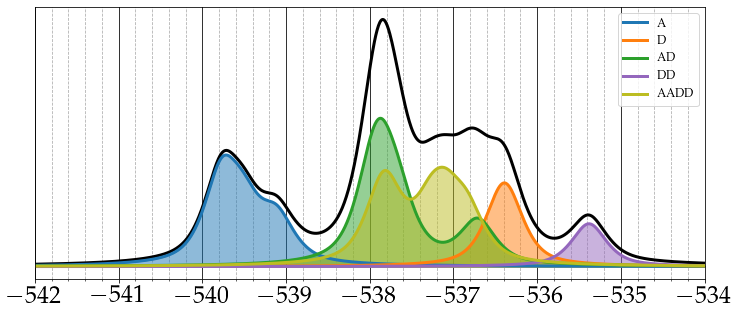

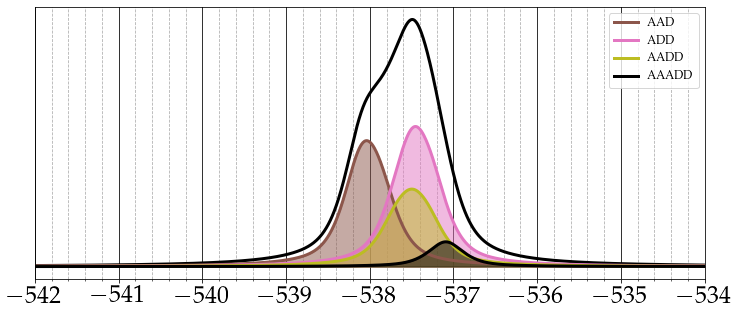

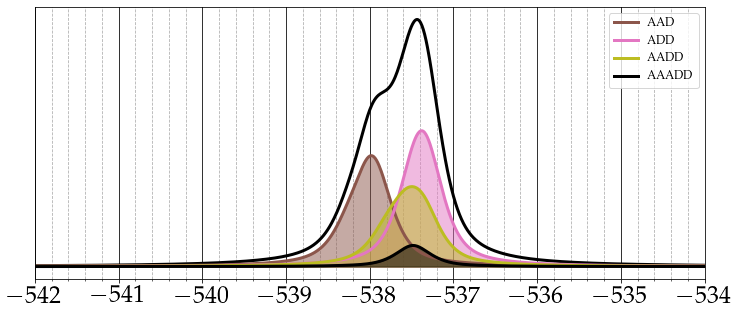

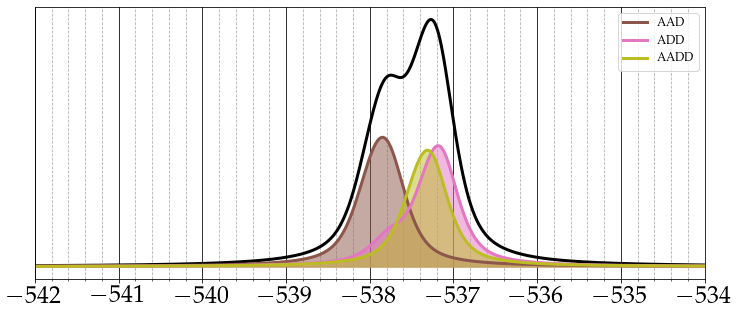

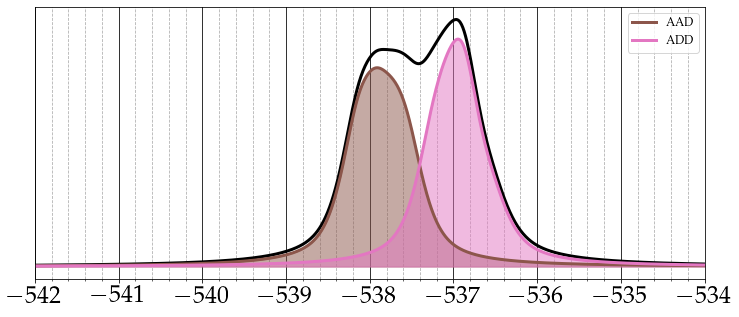

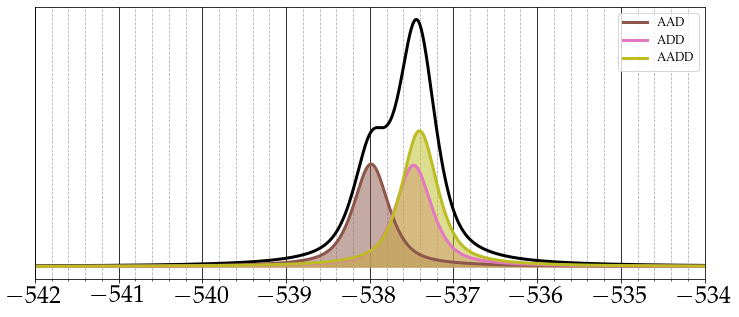

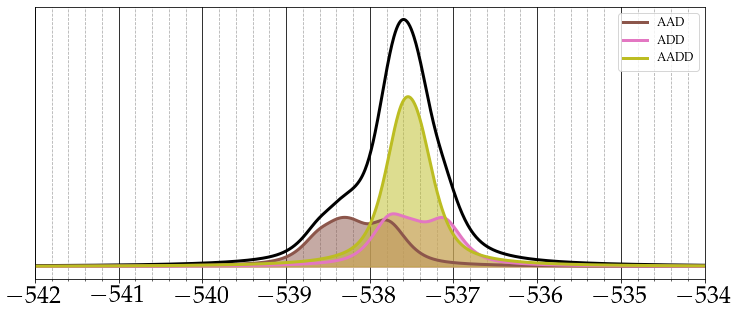

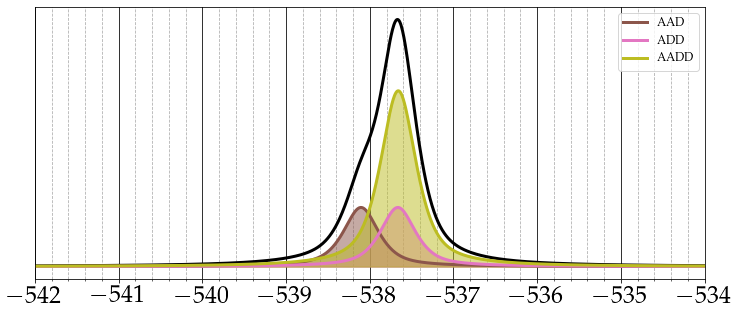

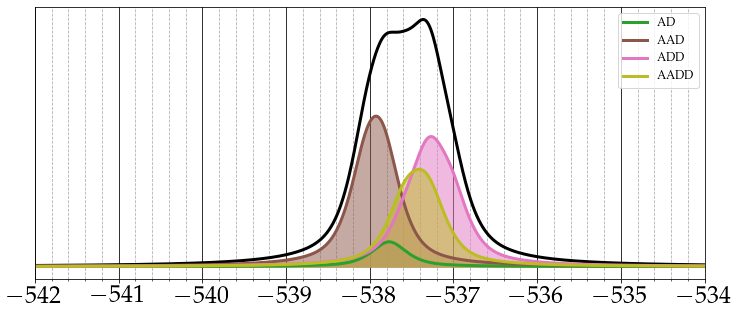

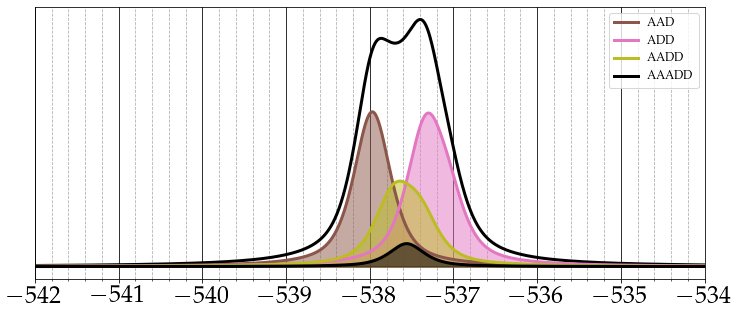

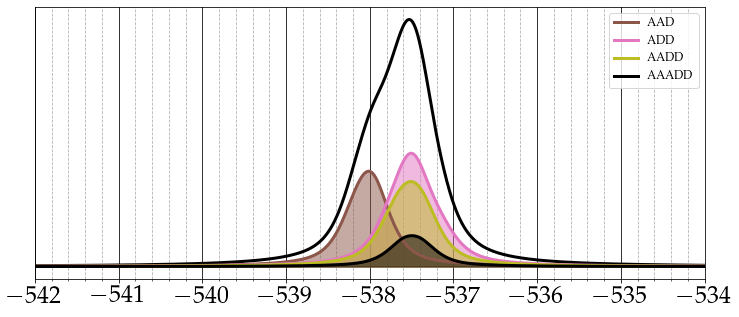

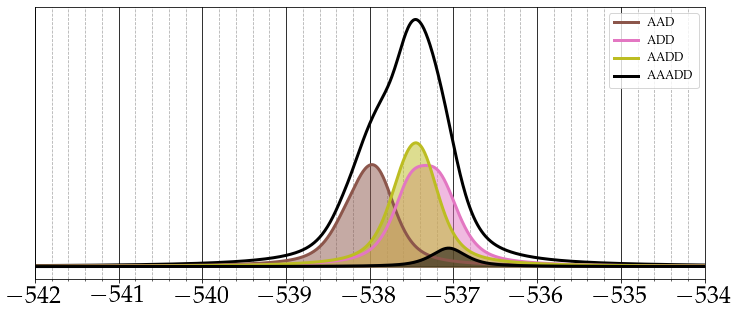

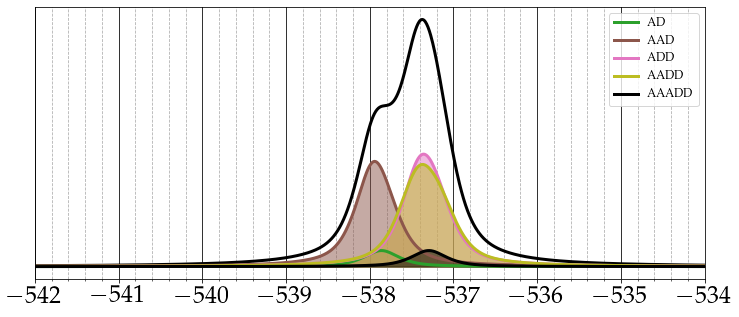

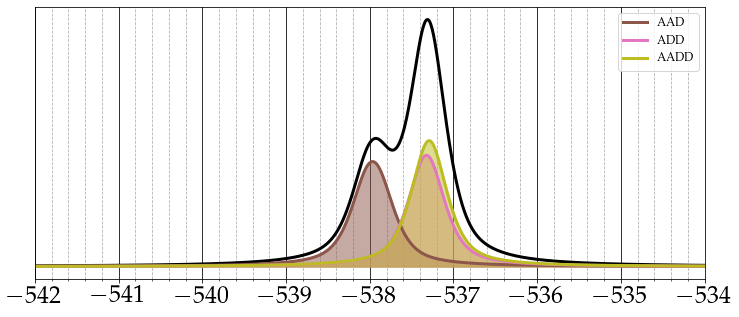

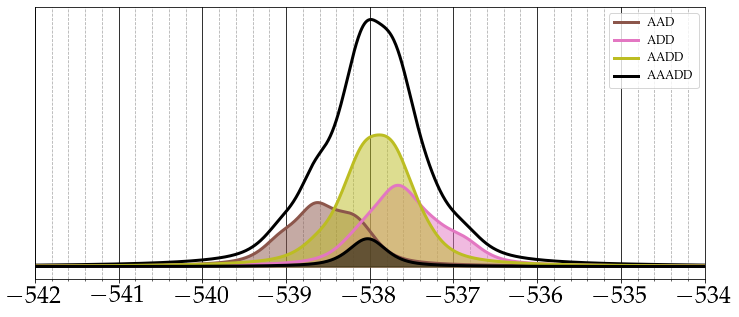

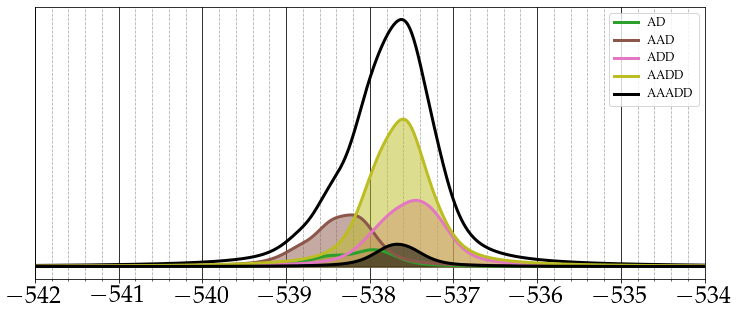

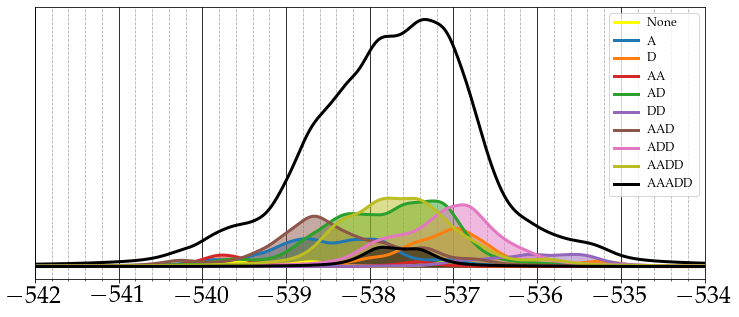

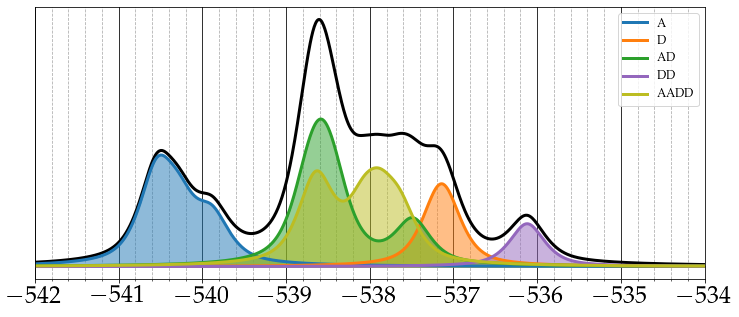

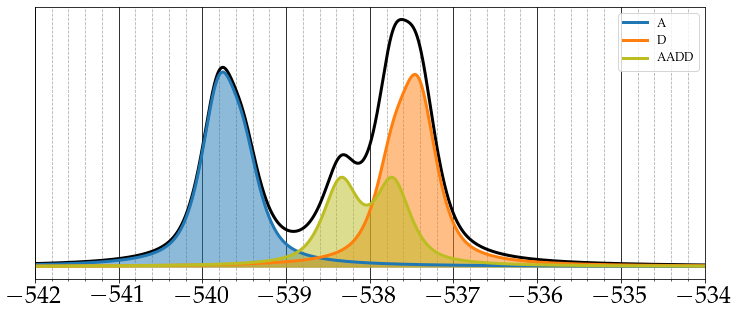

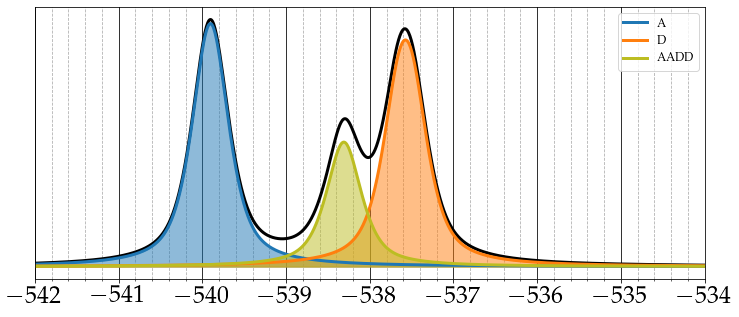

In [10]:
for i, file in enumerate(g0w0_df["filename"]):
    path = find(file,"../xyz")
    _label = getlabels(path)
    _labels = [_label[j-1] for j in g0w0_df["mol_indices"][i]]
    for j,label in enumerate(_labels):
        if label == "": _labels[j] = "None"
    #if i==0: _labels[0] = 'None'
    _colors = [ colors_dict.setdefault(item,"None") for item in _labels ]
    h=4.0 if i > 40 else 1.0
    
    _spectrum = spectrum(_xs,-np.array(g0w0_df["energies_g0w0"][i]))
    _max_ind = argrelextrema(_spectrum, np.greater)
    
    fig, ax = plt.subplots(1,1, figsize=(12,5))
    ax.margins(x=0)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.grid(which='major',color='black')
    ax.grid(which='minor', linestyle="--")
    ax.yaxis.set_visible(False)
    ax.plot(_xs,_spectrum,color='black',linewidth=3)
    #ax.fill_between(_xs,0,_spectrum,alpha=0.5,color='gray')
    for label in ["None","A","D","AA","AD","DD","AAD","ADD","AADD","AAADD"]:
        _spectrum = np.zeros(len(_xs))
        for j,qp in enumerate(g0w0_df["energies_g0w0"][i]):
            if _labels[j]==label: _spectrum += spectrum(_xs,[-qp])
        if sum(_spectrum) > 0.0: 
            ax.plot(_xs,_spectrum,color=colors_dict[label],label=label,linewidth=3)
            ax.fill_between(_xs,0,_spectrum,alpha=0.5,color=colors_dict[label])
    ax.legend(fontsize=12)
    plt.show()
